In [1]:
# Implementing SimCLR model over the dataset

# Reference for code : https://github.com/sthalles/SimCLR

In [2]:
!rm -rf "/kaggle/working"

rm: cannot remove '/kaggle/working': Device or resource busy


In [3]:
# Code for clearing memory

import torch
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [4]:
ROOT_FOLDERS_TRAIN_DATA = ['/kaggle/input/ssl-dataset/ssl_dataset/train.X1','/kaggle/input/ssl-dataset/ssl_dataset/train.X2','/kaggle/input/ssl-dataset/ssl_dataset/train.X3','/kaggle/input/ssl-dataset/ssl_dataset/train.X4']

In [5]:
# Imports Combined

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torchvision import datasets

from tqdm import tqdm
# 
import os
import sys
import logging

import yaml
import argparse

import re

torch.manual_seed(0)
np.random.seed(0)

2025-05-27 10:37:41.636731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748342261.840052      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748342261.898518      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# exceptions/exceptions.py

class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""

In [7]:
# data_aug/view_generator.py

# import numpy as np

# np.random.seed(0)


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]

In [8]:
# data_aug/gaussian_blur.py


# import numpy as np
# import torch
# from torch import nn
# from torchvision.transforms import transforms

# np.random.seed(0)


class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

In [9]:
# data_aug/contrastive_learning_dataset.py

# from torchvision.transforms import transforms
# from data_aug.gaussian_blur import GaussianBlur
# from torchvision import transforms, datasets
# from data_aug.view_generator import ContrastiveLearningViewGenerator
# from exceptions.exceptions import InvalidDatasetSelection


class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder

    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        """Return a set of data augmentation transformations as described in the SimCLR paper."""
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomApply([color_jitter], p=0.8),
                                              transforms.RandomGrayscale(p=0.2),
                                              GaussianBlur(kernel_size=int(0.1 * size)),
                                              transforms.ToTensor()])
        return data_transforms

    def get_dataset(self, name, n_views):
        valid_datasets = {'cifar10': lambda: datasets.CIFAR10(self.root_folder, train=True,
                                                              transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(32),
                                                                  n_views),
                                                              download=True),

                          'stl10': lambda: datasets.STL10(self.root_folder, split='unlabeled',
                                                          transform=ContrastiveLearningViewGenerator(
                                                              self.get_simclr_pipeline_transform(96),
                                                              n_views),
                                                          download=True),
                          'custom': lambda: datasets.ImageFolder(self.root_folder,
                                                  transform=ContrastiveLearningViewGenerator(
                                                              self.get_simclr_pipeline_transform(224),
                                                                n_views)),
                                                                 }

        try:
            dataset_fn = valid_datasets[name]
        except KeyError:
            raise InvalidDatasetSelection()
        else:
            return dataset_fn()

In [10]:
# models/resnet_simclr.py

# import torch.nn as nn
# import torchvision.models as models
# from exceptions.exceptions import InvalidBackboneError


class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name = 'resnet50'):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

In [11]:
# utils.py

# import os

# import torch
# import yaml


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    if is_best:
        best_checkpoint_path = '/kaggle/working/model/model_best.pth.tar'
        os.makedirs(os.path.dirname(best_checkpoint_path), exist_ok=True)
        torch.save(state, best_checkpoint_path)
    else:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        torch.save(state, filename)
    
def get_latest_checkpoint_epoch(checkpoint_dir):
    checkpoint_files = os.listdir(checkpoint_dir)
    pattern = re.compile(r"checkpoint_epoch_(\d+)\.pth\.tar")
    epochs = []
    for fname in checkpoint_files:
        match = pattern.match(fname)
        if match:
            epochs.append((int(match.group(1)), fname))
    if not epochs:
        raise FileNotFoundError("No checkpoint files found in directory.")
    # Get latest checkpoint by epoch number
    latest_epoch, latest_fname = max(epochs, key=lambda x: x[0])
    return latest_epoch, os.path.join(checkpoint_dir, latest_fname)

def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [12]:
# simclr.py

# import logging
# import os
# import sys

# import torch
# import torch.nn.functional as F
# from torch.cuda.amp import GradScaler, autocast
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
# from utils import save_config_file, accuracy, save_checkpoint

# torch.manual_seed(0)


class SimCLR(object):

    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.writer = SummaryWriter()
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)
        
        logging_path = "/kaggle/working/logs"
        os.makedirs(logging_path, exist_ok=True)
        
        log_file = os.path.join(logging_path, 'training.log')
        
        # Remove all existing handlers
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)
        
        logging.basicConfig(
            filename=log_file,
            level=logging.DEBUG,
            filemode='w',
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger()
        
    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.args.batch_size) for i in range(self.args.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.args.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)


        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.args.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.args.device)

        logits = logits / self.args.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler('cuda', enabled=self.args.fp16_precision)

        # save config file
        save_config_file(self.writer.log_dir, self.args)

        n_iter = 0
        best_loss = float('inf') 
        self.logger.info(f"Start SimCLR training for {self.args.epochs} epochs.")
        self.logger.info(f"Training with gpu: {not self.args.disable_cuda}.")

        starting_epoch, checkpoint_path = get_latest_checkpoint_epoch("/kaggle/input/simclr-model/runs/May26_22-27-46_ca41811d77bd")
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location=self.args.device)
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.logger.info(f"Resumed training from checkpoint: {checkpoint_path}, epoch {starting_epoch}")
            print(f"training started from {starting_epoch} epoch")
            
        for epoch_counter in range(starting_epoch, self.args.epochs+starting_epoch):
            epoch_loss = 0.0
            num_batches = 0
            
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_counter}", leave=False)
            for images, _ in progress_bar:
                images = torch.cat(images, dim=0)

                images = images.to(self.args.device)

                with autocast('cuda', enabled=self.args.fp16_precision):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                epoch_loss += loss.item()
                num_batches += 1

                progress_bar.set_postfix(loss=loss.item()) 

                if n_iter % self.args.log_every_n_steps == 0:
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    self.writer.add_scalar('loss', loss.item(), global_step=n_iter)
                    self.writer.add_scalar('acc/top1', top1[0], global_step=n_iter)
                    self.writer.add_scalar('acc/top5', top5[0], global_step=n_iter)
                    self.writer.add_scalar('learning_rate', self.scheduler.get_lr()[0], global_step=n_iter)

                n_iter += 1
            
            
            avg_epoch_loss = epoch_loss / num_batches
            self.writer.add_scalar('epoch_loss', avg_epoch_loss, global_step=epoch_counter)

            if (epoch_counter + 1) % 5 == 0:
                checkpoint_path = os.path.join(
                    self.writer.log_dir, f'checkpoint_epoch_{epoch_counter+1:04d}.pth.tar'
                )
                save_checkpoint({
                    'epoch': epoch_counter + 1,
                    'arch': self.args.arch,
                    'state_dict': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                }, is_best=False, filename=checkpoint_path)
                self.logger.info(f"Checkpoint saved at epoch {epoch_counter+1}")

            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                best_checkpoint_path = os.path.join(self.writer.log_dir,  f'checkpoint_epoch_{epoch_counter+1:04d}.pth.tar')
                save_checkpoint({
                    'epoch': epoch_counter + 1,
                    'arch': self.args.arch,
                    'state_dict': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                }, is_best=True, filename=best_checkpoint_path)
                self.logger.info(f"Best model updated at epoch {epoch_counter+1} with loss {best_loss:.4f}")
                
            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            self.logger.debug(f"Epoch: {epoch_counter}\tAvg Loss: {avg_epoch_loss:.4f}\tTop1 accuracy: {top1[0]}")

        self.logger.info("Training has finished.")

In [13]:
# run.py

# import argparse
# import torch
# import torch.backends.cudnn as cudnn
# from torchvision import models
# from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
# from models.resnet_simclr import ResNetSimCLR
# from simclr import SimCLR

model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))

parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument('-data', metavar='DIR', default='/kaggle/input/ssl-dataset/ssl_dataset/train.X1',
                    help='path to dataset')
parser.add_argument('-dataset-name', default='custom',
                    help='dataset name', choices=['stl10', 'cifar10', 'custom'])
parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet50',
                    choices=model_names,
                    help='model architecture: ' +
                         ' | '.join(model_names) +
                         ' (default: resnet50)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=50, type=int, metavar='N', # EPOCHS
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=0.0003, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--fp16-precision', action='store_true', default=True,
                    help='Whether or not to use 16-bit precision GPU training.')
parser.add_argument('--out_dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--log-every-n-steps', default=1, type=int,
                    help='Log every n steps')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')
parser.add_argument('--n-views', default=2, type=int, metavar='N',
                    help='Number of views for contrastive learning training.')


def main():
    args, unknown = parser.parse_known_args()
    assert args.n_views == 2, "Only two view training is supported. Please use --n-views 2."

    if not args.disable_cuda and torch.cuda.is_available():
        args.device = torch.device('cuda')
        cudnn.deterministic = True
        cudnn.benchmark = True
    else:
        args.device = torch.device('cpu')
        args.gpu_index = -1

    dataset = ContrastiveLearningDataset(args.data)

    train_dataset = dataset.get_dataset(args.dataset_name, args.n_views)
    print(f"Total samples in dataset: {len(train_dataset)}")
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True, drop_last=True)

    model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        model = torch.nn.DataParallel(model)

    optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.weight_decay)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                           last_epoch=-1)

    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)


if __name__ == "__main__":
    main()

Total samples in dataset: 32500


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using 2 GPUs.
training started from 50 epoch


Epoch 50:   0%|          | 0/126 [00:32<?, ?it/s, loss=1.33]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Total samples in dataset: 32500


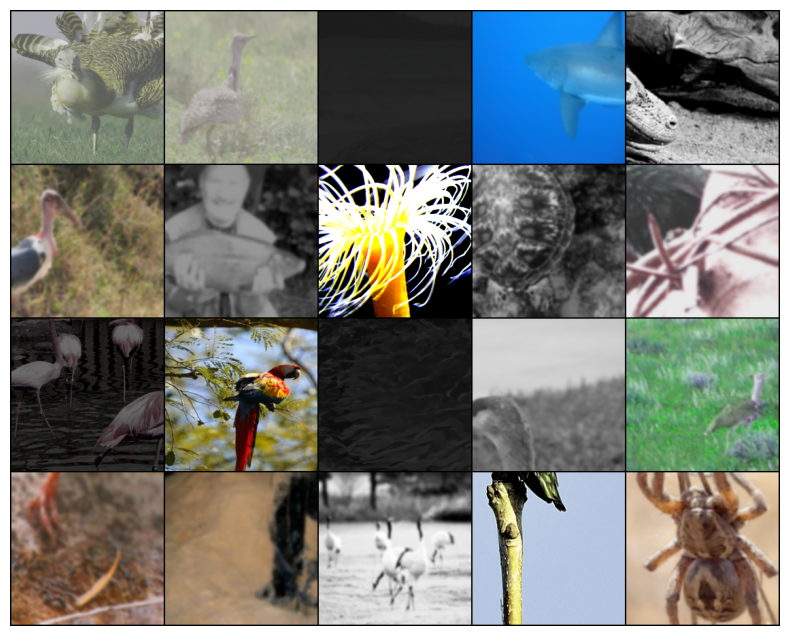

In [14]:
# Visualization of some examples in a batch

import matplotlib.pyplot as plt
import torchvision.utils as vutils


args, unknown = parser.parse_known_args()

dataset = ContrastiveLearningDataset(args.data)

train_dataset = dataset.get_dataset(args.dataset_name, args.n_views)
print(f"Total samples in dataset: {len(train_dataset)}")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, drop_last=True)

images, labels = next(iter(train_loader))

images_tensor = torch.cat(images, dim=0)

grid_img = vutils.make_grid(images_tensor[:20], nrow=5, padding=2)

np_img = grid_img.numpy().transpose((1, 2, 0))

plt.figure(figsize=(10, 8))
plt.imshow(np_img)
plt.axis('off')
plt.show()